<a href="https://colab.research.google.com/github/mitramir55/kaggle-sentiment-analysis-project/blob/main/Transformers_with_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-o7bu5oej
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-o7bu5oej
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-3.4.0-cp36-none-any.whl size=1257324 sha256=a3e0bcb1c588761673eb7d95199321b1c28f8c44af66c4b80f08face9002cac2
  Stored in directory: /tmp/pip-ephem-wheel-cache-mhyb1hz9/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers


In [2]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [3]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 3.4.0


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [5]:

!git clone https://github.com/mitramir55/kaggle-sentiment-analysis-project.git
train = pd.read_csv('kaggle-sentiment-analysis-project/train.tsv', sep = '\t')
test = pd.read_csv('kaggle-sentiment-analysis-project/test.tsv', sep = '\t')
#sample_sub = pd.read_csv('kaggle-sentiment-analysis-project/sample_submission.csv')

fatal: destination path 'kaggle-sentiment-analysis-project' already exists and is not an empty directory.


In [6]:
import string
def clean(tweet, http = True, punc = True, lem = True, stop_w = True):
    
    if http is True:
        tweet = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", '', tweet)

    
    if stop_w == 'nltk':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in nltk_st]
        tweet = ' '.join(tweet)

    elif stop_w == 'spacy':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in spacy_st]
        tweet = ' '.join(tweet)

    # lemmitizing
    if lem == True:
        lemmatized = [word.lemma_ for word in sp(tweet)]
        tweet = ' '.join(lemmatized)

    # punctuation removal
    if punc is True:
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
        
    # removing extra space
    tweet = re.sub("\s+", ' ', tweet)
    
    return tweet
train['Phrase'] = train.Phrase.apply(lambda x: clean(x, lem = False, stop_w = False, http = False, punc = True))
test['Phrase'] = test.Phrase.apply(lambda x: clean(x, lem = False, stop_w = False, http = False, punc = True))


In [7]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [8]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [9]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
#transformers.RobertaForSequenceClassification.pretrained_model_archive_map.keys()

In [10]:
class TransformersBaseTokenizer(BaseTokenizer):
    """it coms from transformers and we want to
    make it compatible with the fast.ai"""

    def __init__(self, pretrained_tokenizer :PreTrainedTokenizer,
                 model_type = 'bert', **kwargs):
        
        # why _pretrained ?
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        """add this max_len to your model"""

        self.model_type = model_type

    def __cal__(self, *args, **kwargs):
        return self
    
    def tokenizer(self, t:str) -> List[str]:
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type == 'roberta':
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space = True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:max_seq_len -2]

            if self.model_type == 'xlnet':
                tokens = tokens + [SEP] + [CLS]
            else:
                tokens = [SEP] + tokens + [CLS]
        return tokens

In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [12]:
# defining transformer tokenizer
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer,
                                                       model_type = model_type)
# giving this transformer tokenizer to fastai tokenizer
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1374: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,


In [ ]:
# we transform tokens to ids : numericalize
# convert ids to tokens : textify

In [13]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer

    def numericalize(self, t: Collection[str]) -> List[int]:
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums: Collection[int], sep = ' ') -> List[str]:
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    # itos: a list of all the words in vocabulary
    # exporting the model
    # whatever comes out will be a dict, int, list, something picklable
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [14]:
transformer_vocab = TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab = transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer = fastai_tokenizer,
                                       include_bos = False,
                                       include_eos = False)
transformer_processor = [tokenize_processor, numericalize_processor]

In fastai the data-containing object that we need to feed to a neural network is called a DataBunch. This is called a ‘bunch’ because it bunches together several PyTorch classes into one. In PyTorch there are two primary data objects: **the DataSet** (which contains all of the data items together with their associated label(s)), and the **DataLoader** (which gives chunks of the items in the DataSet to the model in ‘batches’ ). For a typical supervised learning problem we will want a ‘training set’ and a ‘validation set’, with a separateDataSet and DataLoader for each. (as well as an optional ‘test set’, which we will ignore here for simplicity) All of these are bundled up into the fastai DataBunch!

In [15]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id


In [16]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)# databunch: batch size, padding, idx of pad
             .databunch(bs=bs , pad_first=pad_first, pad_idx=pad_idx))

In [15]:
print('CLS token in RoBERTa: ', transformer_tokenizer.cls_token)
print('SEP token in RoBERTa: ', transformer_tokenizer.sep_token)
print('pad in RoBERTa: ', transformer_tokenizer.pad_token)
print('CLS id in RoBERTa: ', transformer_tokenizer.cls_token_id)
print('SEP id in RoBERTa: ', transformer_tokenizer.sep_token_id)
print('pad id in RoBERTa: ', transformer_tokenizer.pad_token_id)

CLS token in RoBERTa:  <s>
SEP token in RoBERTa:  </s>
pad in RoBERTa:  <pad>
CLS id in RoBERTa:  0
SEP id in RoBERTa:  2
pad id in RoBERTa:  1


In [ ]:
sent = "Hello babe, It's me"
tokens = transformer_tokenizer.tokenize(sent)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print('tokens are: \n', tokens)
print('ids are: \n', ids)

tokens are: 
 ['Hello', 'Ġbabe', ',', 'ĠIt', "'s", 'Ġme']
ids are: 
 [31414, 37502, 6, 85, 18, 162]


In [ ]:
transformer_base_tokenizer.tokenizer("me I'm so good, meee")

['<s>', 'Ġme', 'ĠI', "'m", 'Ġso', 'Ġgood', ',', 'Ġme', 'ee', '</s>']

In [ ]:
print('CLS token in BERT: ', transformer_tokenizer.cls_token)
print('SEP token in BERTa: ', transformer_tokenizer.sep_token)
print('pad in BERTa: ', transformer_tokenizer.pad_token)
print('CLS id in BERTa: ', transformer_tokenizer.cls_token_id)
print('SEP id in BERTa: ', transformer_tokenizer.sep_token_id)
print('pad id in BERTa: ', transformer_tokenizer.pad_token_id)

CLS token in BERT:  [CLS]
SEP token in BERTa:  [SEP]
pad in BERTa:  [PAD]
CLS id in BERTa:  101
SEP id in BERTa:  102
pad id in BERTa:  0


In [ ]:
sent = "Hello babe, It's me"
tokens = transformer_tokenizer.tokenize(sent)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print('tokens are: \n', tokens)
print('ids are: \n', ids)

In [17]:
databunch.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
<s> ĠL RB ĠCity ĠRR B Ġreminds Ġus Ġhow Ġrealistically Ġnuanced Ġa ĠRobert ĠDe ĠN iro Ġperformance Ġcan Ġbe Ġwhen Ġhe Ġis Ġnot Ġmore Ġluc r atively Ġengaged Ġin Ġthe Ġshameless Ġself car ic ature Ġof ĠAnaly ze ĠThis ĠL RB Ġ1999 ĠRR B Ġand ĠAnaly ze ĠThat Ġpromised ĠL RB Ġor Ġthreatened ĠRR B Ġfor Ġlater Ġthis Ġyear Ġ </s>,3
<s> ĠThe Ġreal Ġtriumph s Ġin ĠIg by Ġcome Ġfrom ĠPhilippe Ġwho Ġmakes ĠOliver Ġfar Ġmore Ġinteresting Ġthan Ġthe Ġcharacter Ġs Ġlines Ġwould Ġsuggest Ġand ĠSar andon Ġwho Ġcould Ġn t Ġbe Ġbetter Ġas Ġa Ġcruel Ġbut Ġweird ly Ġlik able ĠWAS P Ġmat ron Ġ </s>,3
<s> ĠParker Ġshould Ġbe Ġcomm ended Ġfor Ġtaking Ġa Ġfresh Ġapproach Ġto Ġfamiliar Ġmaterial Ġbut Ġhis Ġdetermination Ġto Ġremain Ġtrue Ġto Ġthe Ġoriginal Ġtext Ġleads Ġhim Ġto Ġadopt Ġa Ġsomewhat Ġman nered Ġtone Ġthat Ġultimately Ġdull s Ġthe Ġhuman Ġtragedy Ġat Ġthe Ġstory Ġs Ġcore </s>,2
<s> ĠA Ġdifferent Ġand Ġemotionally Ġreserved Ġtype Ġof Ġsurvival Ġstory Ġa Ġfilm Ġless Ġabout Ġref ract ing Ġall Ġof ĠWorld ĠWar ĠII Ġthrough Ġthe Ġspecific Ġconditions Ġof Ġone Ġman Ġand Ġmore Ġabout Ġthat Ġman Ġlost Ġin Ġits Ġmidst Ġ </s>,3
<s> ĠIt Ġs Ġa Ġlong Ġway Ġfrom ĠOrwell Ġs Ġdark Ġintelligent Ġwarning Ġcry ĠL RB Ġ1984 ĠRR B Ġto Ġthe Ġempty Ġstud Ġknock about Ġof ĠEqu ilibrium Ġand Ġwhat Ġonce Ġwas Ġconviction Ġis Ġnow Ġaffect ation Ġ </s>,1


In [ ]:
databunch.one_batch()

In [19]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel, self).__init__()
        self.transformer = transformer_model

    def forward(self, input_ids, attention_mask = None):
        attention_mask = (input_ids!=pad_idx).type(input_ids.type())
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]

        return logits

In [41]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [42]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model= transformer_model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [43]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial


In [44]:
CustomAdamW = partial(AdamW, correct_bias = False)
loss_func = nn.BCEWithLogitsLoss()
learner = Learner(databunch,
                  custom_transformer_model,
                  opt_func = CustomAdamW,
                  metrics = [accuracy, error_rate])



learner.callbacks.append(ShowGraph(learner))

if use_fp16: learner = learner.to_fp16()

In [45]:
learner.save('untrain')
seed_all(seed)
learner.load('untrain');


In [ ]:
print(learner.model)

In [46]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [61, 768]            38,603,520 True      
______________________________________________________________________
Embedding            [61, 768]            394,752    True      
______________________________________________________________________
Embedding            [61, 768]            768        True      
______________________________________________________________________
LayerNorm            [61, 768]            1,536      True      
______________________________________________________________________
Dropout              [61, 768]            0          False     
______________________________________________________________________
Linear               [61, 768]            590,592    True      
______________________________________________________________________
Linear               [61, 768]            590,592    True      
_______________________________________

In [ ]:
learner.freeze_to(-1)

In [46]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [47]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-05
Min loss divided by 10: 1.91E-05


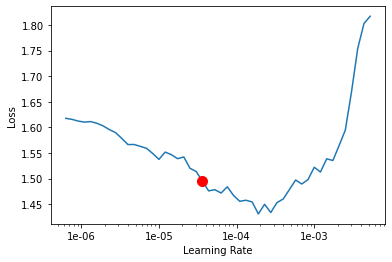

In [48]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [49]:
learner.fit_one_cycle(1, max_lr=2e-05,  moms =(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,error_rate,time


KeyboardInterrupt: ignored